In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from time import time

pitch = pd.read_excel("reduced_delanteros.xlsx")

numeric_vars = ['Transfer_value', 'Exp_contr', 'Age', 'Minutes_pl', 'Minutes_pl_BC', 'NP_goals', 'Pen_goals', 'Pen_goals_BC', 'Assists', 'Interceptions', 'GCA_BC', 'Yellow_cards', 'Red_cards']
pitch[numeric_vars] = StandardScaler().fit_transform(pitch[numeric_vars])

In [2]:
ind_vars = ['Exp_contr', 'Age', 'Minutes_pl', 'Minutes_pl_BC',
       'NP_goals', 'Pen_goals', 'Pen_goals_BC', 'Assists', 'Interceptions',
       'GCA_BC', 'Yellow_cards', 'Red_cards', 'Reduced_team_from_Inter',
       'Reduced_team_from_AC Milan', 'Reduced_team_from_Juventus',
       'Reduced_team_from_Napoli', 'Reduced_team_from_Paris SG',
       'Reduced_team_from_Real Madrid', 'Reduced_team_from_Barcelona',
       'Reduced_team_from_Atlético Madrid', 'Reduced_team_from_Bayern Munich',
       'Reduced_team_from_Bor. Dortmund', 'Reduced_team_from_Chelsea',
       'Reduced_team_from_Arsenal', 'Reduced_team_from_Man City',
       'Reduced_team_from_Man Utd', 'Reduced_team_from_Liverpool', 'Reduced_country_from_Inglaterra',
       'Reduced_country_from_Francia', 'Reduced_country_from_España',
       'Reduced_country_from_Italia', 'Reduced_country_from_Alemania',
       'Reduced_country_from_Portugal', 'Reduced_country_from_Países Bajos',
       'Reduced_country_from_Argentina', 'Reduced_country_from_Brasil']

PermutationExplainer explainer: 1257it [05:04,  4.12it/s]                                                              
C:\Users\elias\AppData\Local\Temp\ipykernel_13776\651485465.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, feature_names = ind_vars)


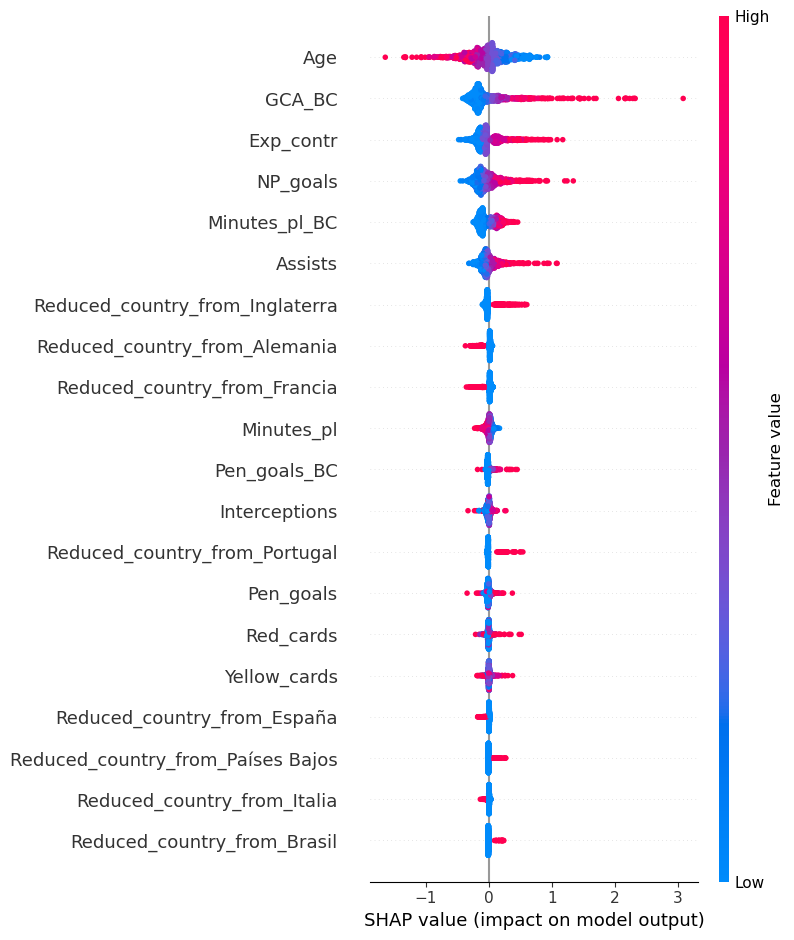

In [3]:
from tensorflow.keras.models import load_model
import shap

modelo_cargado = load_model("delanteros_2.keras")
X = np.array(pitch[ind_vars])  # Asegúrate de usar las variables significativas

explainer = shap.Explainer(modelo_cargado, X)  # No necesitas un masker explícito aquí
shap_values = explainer(X)

shap.summary_plot(shap_values, X, feature_names = ind_vars)

In [3]:
res = pd.DataFrame({
    'dropouts': [],
    'neurons_1': [],
    'neurons_2': [],
    'activations': [],
    'optimizers': [],
    'loss_function': [],
    'batchs': [],
    'loss': [],
    'val_loss': [],
    'Epochs': [],
    'R2': [],
    'MAE': []
})

In [4]:
time0 = time()

# 450 pruebas

dropouts = [0, 0.1, 0.2]
neurons_1 = [64, 128, 256, 512, 1024]
neurons_2 = [16, 32, 64, 128, 256, 512]
activations = ['relu']
optimizers = ['adam']
loss_f = ['mae']
batchs = [8, 16, 32, 64, 128]      
         
max_r2 = -10
for dropout in dropouts:
    for n1 in neurons_1:
        for n2 in neurons_2:
            for activation in activations:
                for optimizer in optimizers:
                    for loss in loss_f:
                        
                        print([dropout, n1, n2, activation, optimizer, loss])
                        print(time() - time0)
                            
                        for batch in batchs:  
                            
                            X = np.array(pitch[ind_vars])  # Asegúrate de usar las variables significativas
                            Y = pitch['Transfer_value']  # Variable dependiente

                            model = Sequential([
                                Dense(n1, activation=activation, input_shape=(X.shape[1],)),
                                Dropout(dropout),
                                Dense(n2, activation=activation),
                                Dropout(dropout),
                                Dense(1)
                            ])

                            model.compile(optimizer=optimizer, loss=loss)

                            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                            history = model.fit(X, Y, epochs=75, batch_size=batch, validation_split=0.2, callbacks=[early_stop], verbose=0);

                            y_pred = model.predict(X)

                
                            r2 = r2_score(Y, y_pred)

                            mae = mean_absolute_error(Y, y_pred)
                            
                            i = history.history['val_loss'].index(min(history.history['val_loss']))
                            l = history.history['loss'][i]
                            vl = history.history['val_loss'][i]
                            
                            nueva_fila = {'dropouts': dropout, 'neurons_1': n1, 'neurons_2': n2, 'activations': activation, 'optimizers': optimizer, 
                                          'loss_function': loss, 'batchs': batch, 'loss': l, 'val_loss': vl, 'Epochs': len(history.epoch), 'R2': r2, 'MAE': mae}
                            serie_nueva_fila = pd.Series(nueva_fila, name=len(res)) # El 'name' se convierte en el índice
                            res = pd.concat([res, pd.DataFrame([nueva_fila])], ignore_index=True)
                            
                            if r2 > max_r2:
                                best_model = model
                                max_r2 = r2

[0, 64, 16, 'relu', 'adam', 'mae']
0.0029947757720947266



40/40 [==============================] - 0s 2ms/step
[0, 64, 32, 'relu', 'adam', 'mae']
15.855337142944336
40/40 [==============================] - 0s 1ms/step
[0, 64, 64, 'relu', 'adam', 'mae']
31.838868379592896
40/40 [==============================] - 0s 1ms/step
[0, 64, 128, 'relu', 'adam', 'mae']
47.86571192741394
40/40 [==============================] - 0s 1ms/step
[0, 64, 256, 'relu', 'adam', 'mae']
60.855029821395874
40/40 [==============================] - 0s 1ms/step
[0, 64, 512, 'relu', 'adam', 'mae']
74.36507892608643
40/40 [==============================] - 0s 1ms/step
[0, 128, 16, 'relu', 'adam', 'mae']
86.57897281646729
40/40 [==============================] - 0s 1ms/step
[0, 128, 32, 'relu', 'adam', 'mae']
98.40209531784058
40/40 [==============================] - 0s 1ms/step
[0, 128, 64, 'relu', 'adam', 'mae']
111.5743625164032
40/40 [==============================] - 0s 1ms/step
[0, 128, 128, 'relu', 'adam', 

40/40 [==============================] - 0s 2ms/step
[0.1, 512, 64, 'relu', 'adam', 'mae']
794.5619351863861
40/40 [==============================] - 0s 2ms/step
[0.1, 512, 128, 'relu', 'adam', 'mae']
813.5205552577972
40/40 [==============================] - 0s 2ms/step
[0.1, 512, 256, 'relu', 'adam', 'mae']
831.7390494346619
40/40 [==============================] - 0s 2ms/step
[0.1, 512, 512, 'relu', 'adam', 'mae']
850.2161571979523
40/40 [==============================] - 0s 2ms/step
[0.1, 1024, 16, 'relu', 'adam', 'mae']
877.7645537853241
40/40 [==============================] - 0s 2ms/step
[0.1, 1024, 32, 'relu', 'adam', 'mae']
893.5060863494873
40/40 [==============================] - 0s 2ms/step
[0.1, 1024, 64, 'relu', 'adam', 'mae']
908.9553966522217
40/40 [==============================] - 0s 3ms/step
[0.1, 1024, 128, 'relu', 'adam', 'mae']
925.082763671875
40/40 [==============================] - 0s 2ms/step
[0.1, 1024, 256, 'relu', 'adam', 'mae']
947.1210236549377
40/40 [===

In [5]:
res.sort_values(by='R2', ascending=False)

,dropouts,neurons_1,neurons_2,activations,optimizers,loss_function,batchs,loss,val_loss,Epochs,R2,MAE
250,0.1,512.0,64.0,relu,adam,mae,8.0,0.281818,0.310033,16.0,0.726190,0.252731
86,0.0,256.0,512.0,relu,adam,mae,16.0,0.274735,0.321494,13.0,0.723199,0.255458
110,0.0,512.0,256.0,relu,adam,mae,8.0,0.291518,0.321777,12.0,0.708323,0.275643
97,0.0,512.0,32.0,relu,adam,mae,32.0,0.269433,0.311318,14.0,0.703403,0.259910
285,0.1,1024.0,128.0,relu,adam,mae,8.0,0.306616,0.318400,12.0,0.699984,0.276658
...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.0,1024.0,32.0,relu,adam,mae,16.0,0.349845,0.308940,7.0,0.541053,0.319245
275,0.1,1024.0,32.0,relu,adam,mae,8.0,0.368284,0.311064,7.0,0.540879,0.326025
164,0.1,64.0,64.0,relu,adam,mae,128.0,0.376991,0.315697,17.0,0.532932,0.334089
251,0.1,512.0,64.0,relu,adam,mae,16.0,0.339222,0.317326,9.0,0.525486,0.325346


In [6]:
# from tensorflow.keras.models import load_model

# # Cargar el modelo
# modelo_cargado = load_model("defensas_2.keras")

best_model.save("delanteros_2.keras")

# 0.1	512.0	512.0	relu	adam	mae	8.0	0.196465	0.362346	32.0	0.846066	0.213519

In [16]:
res_2 = pd.DataFrame({
    'dropouts': [],
    'neurons_1': [],
    'neurons_2': [],
    'neurons_3': [],
    'activations': [],
    'optimizers': [],
    'loss_function': [],
    'batchs': [],
    'loss': [],
    'val_loss': [],
    'Epochs': [],
    'R2': [],
    'MAE': []
})

In [17]:
time0 = time()

# 1323 pruebas

dropouts = [0.2]  # 0.1, 0.2, 0.3, 0.4
neurons_1 = [16, 32, 64, 128, 256, 512, 1024]
neurons_2 = [8, 16, 32, 64, 128, 256, 512]
neurons_3 = [2, 3, 4]
activations = ['relu']
optimizers = ['adam']
loss_f = ['mae']
batchs = [8, 16, 32]      

max_r2 = -10
for dropout in dropouts:
    for n1 in neurons_1:
        for n2 in neurons_2:
            for n3 in neurons_3:
                print([dropout, n1, n2, n3])
                print(time() - time0)
                for activation in activations:
                    for optimizer in optimizers:
                        for loss in loss_f:                            
                            for batch in batchs:  

                                X = np.array(pitch[ind_vars])  # Asegúrate de usar las variables significativas
                                Y = pitch['Transfer_value']  # Variable dependiente

                                model = Sequential([
                                    Dense(n1, activation=activation, input_shape=(X.shape[1],)),
                                    Dropout(dropout),
                                    Dense(n2, activation=activation),
                                    Dropout(dropout),
                                    Dense(n3, activation=activation),
                                    Dropout(dropout),
                                    Dense(1)
                                ])

                                model.compile(optimizer=optimizer, loss=loss)

                                early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

                                history = model.fit(X, Y, epochs=75, batch_size=batch, validation_split=0.2, callbacks=[early_stop], verbose=0);

                                y_pred = model.predict(X, verbose=0)


                                r2 = r2_score(Y, y_pred)

                                mae = mean_absolute_error(Y, y_pred)

                                i = history.history['val_loss'].index(min(history.history['val_loss']))
                                l = history.history['loss'][i]
                                vl = history.history['val_loss'][i]

                                nueva_fila = {'dropouts': dropout, 'neurons_1': n1, 'neurons_2': n2, 'neurons_3': n3, 'activations': activation, 'optimizers': optimizer, 
                                              'loss_function': loss, 'batchs': batch, 'loss': l, 'val_loss': vl, 'Epochs': len(history.epoch), 'R2': r2, 'MAE': mae}
                                serie_nueva_fila = pd.Series(nueva_fila, name=len(res_2)) # El 'name' se convierte en el índice
                                res_2 = pd.concat([res_2, pd.DataFrame([nueva_fila])], ignore_index=True)    
                                
                                if r2 > max_r2:
                                    best_model = model
                                    max_r2 = r2

[0.2, 16, 8, 2]
0.0019991397857666016
[0.2, 16, 8, 3]
24.61574912071228
[0.2, 16, 8, 4]
48.458006858825684
[0.2, 16, 16, 2]
72.57969808578491
[0.2, 16, 16, 3]
95.34536290168762
[0.2, 16, 16, 4]
117.96323275566101
[0.2, 16, 32, 2]
136.64103269577026
[0.2, 16, 32, 3]
158.4777762889862
[0.2, 16, 32, 4]
185.87769675254822
[0.2, 16, 64, 2]
204.73444819450378
[0.2, 16, 64, 3]
226.10109972953796
[0.2, 16, 64, 4]
250.13626980781555
[0.2, 16, 128, 2]
270.4089081287384
[0.2, 16, 128, 3]
289.25639033317566
[0.2, 16, 128, 4]
305.305871963501
[0.2, 16, 256, 2]
320.86260890960693
[0.2, 16, 256, 3]
337.3855016231537
[0.2, 16, 256, 4]
351.49864435195923
[0.2, 16, 512, 2]
367.3331506252289
[0.2, 16, 512, 3]
388.2948613166809
[0.2, 16, 512, 4]
407.2220013141632
[0.2, 32, 8, 2]
427.1765351295471
[0.2, 32, 8, 3]
446.7380881309509
[0.2, 32, 8, 4]
461.983904838562
[0.2, 32, 16, 2]
486.3641746044159
[0.2, 32, 16, 3]
511.64097261428833
[0.2, 32, 16, 4]
536.4210307598114
[0.2, 32, 32, 2]
553.6900930404663
[0.2

In [18]:
res_2.sort_values(by='R2', ascending=False)

,dropouts,neurons_1,neurons_2,neurons_3,activations,optimizers,loss_function,batchs,loss,val_loss,Epochs,R2,MAE
400,0.2,1024.0,32.0,3.0,relu,adam,mae,16.0,0.333205,0.315348,22.0,0.694542,0.281842
422,0.2,1024.0,128.0,4.0,relu,adam,mae,32.0,0.364308,0.310967,18.0,0.693534,0.279419
226,0.2,128.0,128.0,2.0,relu,adam,mae,16.0,0.346709,0.308658,19.0,0.687957,0.298642
296,0.2,256.0,128.0,4.0,relu,adam,mae,32.0,0.358087,0.329113,23.0,0.686513,0.302190
301,0.2,256.0,256.0,3.0,relu,adam,mae,16.0,0.335343,0.303569,23.0,0.682150,0.277703
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,0.2,16.0,8.0,2.0,relu,adam,mae,32.0,0.509676,0.391465,25.0,0.039183,0.462017
47,0.2,16.0,256.0,2.0,relu,adam,mae,32.0,0.552486,0.460932,23.0,-0.120069,0.533889
361,0.2,512.0,256.0,2.0,relu,adam,mae,16.0,0.552902,0.460931,15.0,-0.120117,0.533884
397,0.2,1024.0,32.0,2.0,relu,adam,mae,16.0,0.552437,0.460929,15.0,-0.122709,0.533723


In [15]:
res_2.to_excel("delanteros_3_1.xlsx", index=False)

In [14]:
best_model.save("delanteros_3_1.keras")

# 0.0	128.0	512.0	3.0	relu	adam	mae	32.0	0.223915	0.344550	28.0	0.793882	0.233181

In [19]:
from tensorflow.keras.models import load_model

modelo_cargado = load_model("delanteros_3.keras")
y_pred = modelo_cargado.predict(X, verbose=0)

r2 = r2_score(Y, y_pred)
mae = mean_absolute_error(Y, y_pred)

print(r2, mae)

0.8536836891040274 0.21307662941951247
